In [51]:
import mysql.connector

def test_mysql_connection(config):
    try:
        # Attempt to establish a connection to the MySQL server
        connection = mysql.connector.connect(**config)
        
        # If connection is successful, print a success message
        if connection.is_connected():
            print("Connection to MySQL server successful")
            # Close the connection
            connection.close()
    except mysql.connector.Error as err:
        # If connection fails, print the error message
        print(f"Error: {err}")

# Configuration dictionary
config = {
    'user': 'jmc',
    'password': 'jmc',
    'host': '10.18.16.100',
    'port': '3307',
    'database': 'Fast_Freeway_Sensor_Data_XIE'
}

# Call the function to test the connection
test_mysql_connection(config)


Error: 2003: Can't connect to MySQL server on '10.18.16.100:3307' (10060 A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond)


In [46]:
# Sensor records separating function

import csv
import os
import mysql
import mysql.connector

def connect_to_mysql():
    # MySQL connection parameters
    config = {
        'user': 'jmc',
        'password': 'jmc',
        'host': '10.18.16.100',
        'port': "3306",
        'database': 'Fast_Freeway_Sensor_Data_XIE'
    }

    # Establishing MySQL connection
    connection = mysql.connector.connect(**config)
    return connection

def fetch_data_and_create_csv(connection, chunk_size=1000):
    cursor = connection.cursor()

    # Selecting data from the table
    query = "SELECT * FROM `2018`"
    cursor.execute(query)

    while True:
        # Fetching rows in chunks
        rows = cursor.fetchmany(chunk_size)

        if not rows:
            break  # No more rows to fetch

        # Creating a folder to store CSV files
        folder_path = "C:/Users/Tarek Zahid/Desktop/xie/sensor_files_separated/2018"
        os.makedirs(folder_path, exist_ok=True)

        # Process data and create CSV files
        for row in rows:
            detector_id = row[22]  
            csv_file_path = os.path.join(folder_path, f"{detector_id}.csv")

            # Appending data to CSV file
            with open(csv_file_path, mode='a', newline='') as csv_file:
                csv_writer = csv.writer(csv_file)
                csv_writer.writerow(row)

    cursor.close()

In [ ]:
connection = connect_to_mysql()
fetch_data_and_create_csv(connection)
connection.close()

In [ ]:
# add header to files

import os
import pandas as pd

def add_header_to_csv_files(folder_path, header):
    # Get a list of CSV files in the folder
    csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

    # Iterate through each CSV file
    for csv_file in csv_files:
        file_path = os.path.join(folder_path, csv_file)

        # Read the CSV file
        df = pd.read_csv(file_path, header=None)

        # Add the header to the DataFrame
        df.columns = header

        # Save the DataFrame back to the CSV file
        df.to_csv(file_path, index=False)

        print(f"Header added to: {csv_file}")

# Example usage:
folder_path = 'C:/Users/Tarek Zahid/Desktop/xie/sensor_files_separated/1. raw individual sensor files/2018'
header = ['DateTimeStamp', 'Path', 'RoadIndex', 'RoadwayID', 'SegmentID', 'Lane', 'DeviceID',
          'Volume', 'Volume1', 'Volume2', 'Volume3', 'Volume4', 'Volume5', 'Volume6', 'Occupancy',
          'Speed', 'Poll_Count', 'Failure', 'RoadType', 'Location', 'Polling_Period', 'Invalid',
          'DetectorID', 'DayOfWeek', 'DateValue', 'HourIdx', 'Holiday']

add_header_to_csv_files(folder_path, header)


Get common csv files in 2018 and 2019

In [3]:
import os
import shutil

def get_common_csv_files(folder1, folder2):
    files_folder1 = set(file for file in os.listdir(folder1) if file.endswith('.csv'))
    files_folder2 = set(file for file in os.listdir(folder2) if file.endswith('.csv'))
    
    common_files = files_folder1.intersection(files_folder2)
    return common_files

def copy_files(source_folder, destination_folder, files_to_copy):
    for file in files_to_copy:
        source_path = os.path.join(source_folder, file)
        destination_path = os.path.join(destination_folder, file)
        shutil.copy2(source_path, destination_path)

# Replace these paths with your actual paths
folder1_path = 'D:/xie_sepa/2018'
folder2_path = 'D:/xie_sepa/2019'
destination_folder1_path = 'D:/xie_sepa/common/2018'
destination_folder2_path = 'D:/xie_sepa/common/2019'

common_files = get_common_csv_files(folder1_path, folder2_path)

# Copy common files to destination folders
copy_files(folder1_path, destination_folder1_path, common_files)
copy_files(folder2_path, destination_folder2_path, common_files)

print("Common CSV files copied successfully.")


Common CSV files copied successfully.


get the aggregated value

In [ ]:
import os
import pandas as pd

def process_csv(source_folder, destination_folder):
    # Create destination folder if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Get a list of CSV files in the source folder
    csv_files = [file for file in os.listdir(source_folder) if file.endswith('.csv')]

    # Iterate through each CSV file
    for idx, csv_file in enumerate(csv_files):
        file_path = os.path.join(source_folder, csv_file)
        destination_path = os.path.join(destination_folder, csv_file)

        # Read CSV file
        df = pd.read_csv(file_path)

        # Check if DataFrame has more than one record for each DateTimeStamp
        multiple_records_mask = df['DateTimeStamp'].duplicated(keep=False)
        df_to_process = df[multiple_records_mask]

        if not df_to_process.empty:
            # Group by DateTimeStamp, calculate aggregates
            grouped_df = df_to_process.groupby(['DateTimeStamp']).agg({
                'Volume': 'sum',
                'Occupancy': 'sum',
                'Speed': 'mean'
            }).reset_index()

            # Save the grouped data to a new CSV file
            grouped_df.to_csv(destination_path, columns=['DateTimeStamp', 'Occupancy', 'Volume', 'Speed'], index=False)

            # Display progress
            progress_percentage = (idx + 1) / len(csv_files) * 100
            print(f"Processed: {progress_percentage:.2f}% - {csv_file}")

# Example usage:
source_folder = 'C:/Users/Tarek Zahid/Desktop/xie/Sensor Files/1. raw individual sensor files/2019'
destination_folder = 'C:/Users/Tarek Zahid/Desktop/xie/Sensor Files/2. transformed sensor files/2019'
process_csv(source_folder, destination_folder)


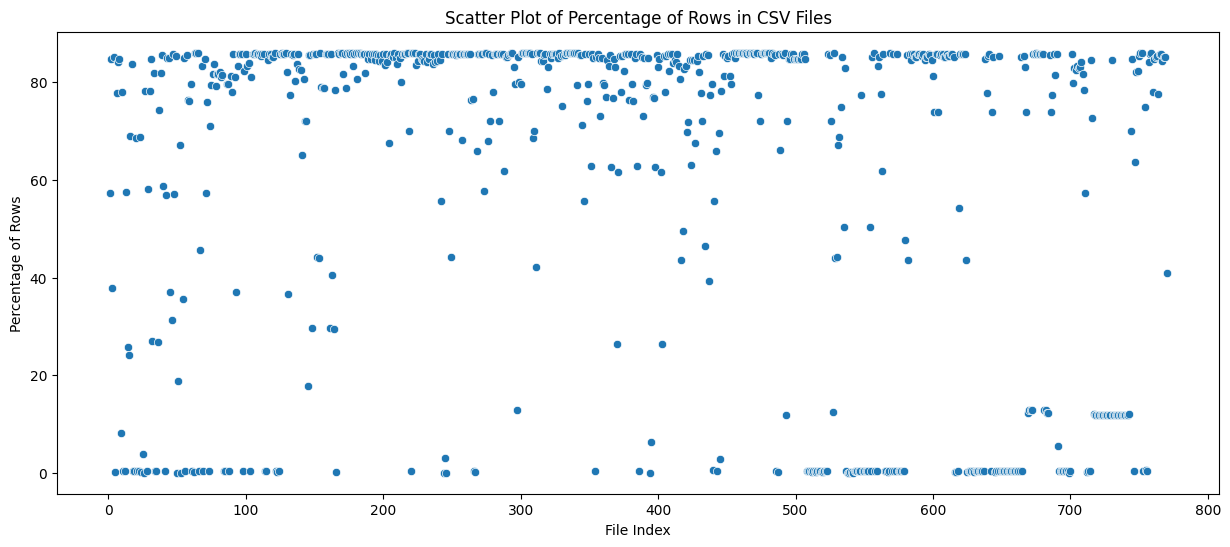

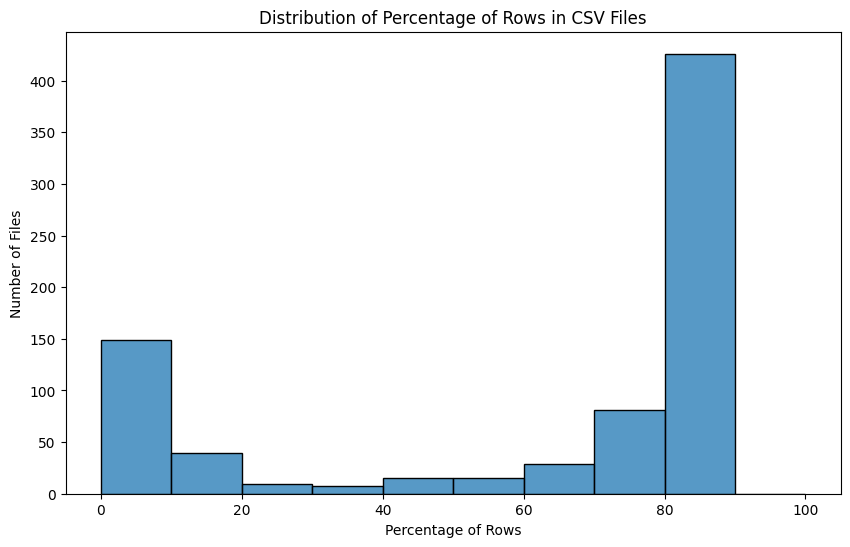

In [22]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def process_csv(directory):
    data = []

    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            filepath = os.path.join(directory, filename)

            df = pd.read_csv(filepath, skiprows=1)
            num_rows = len(df)
            percentage = (num_rows / 35040) * 100

            # Append to the data list
            data.append(percentage)

    return data

def create_scatter_plot(data):
    plt.figure(figsize=(15, 6))  
    sns.scatterplot(x=range(1, len(data) + 1), y=data)
    
    plt.xlabel('File Index')
    plt.ylabel('Percentage of Rows')
    plt.title('Scatter Plot of Percentage of Rows in CSV Files')

    # Show the plot
    plt.show()

def create_histogram(data):
    plt.figure(figsize=(10, 6))
    sns.histplot(data, bins=range(0, 110, 10), kde=False)
    
    plt.xlabel('Percentage of Rows')
    plt.ylabel('Number of Files')
    plt.title('Distribution of Percentage of Rows in CSV Files')
    plt.show()

if __name__ == "__main__":
    csv_directory = 'D:/xie_sepa/agg/2018'

    csv_data = process_csv(csv_directory)
    create_scatter_plot(csv_data)
    create_histogram(csv_data)


In [ ]:
def create_histogram(data):
    plt.figure(figsize=(10, 6))
    sns.histplot(data, bins=range(0, 110, 10), kde=False, cumulative=True)
    
    plt.xlabel('Percentage of Rows')
    plt.ylabel('Cumulative Number of Files')
    plt.title('Cumulative Distribution of Percentage of Rows in CSV Files')
    plt.show()

# data imputation routine:: 

In [2]:
#CSV File Filtering based on Row Count

import os
import shutil
import pandas as pd

source_directory = "D:/xie_sepa/agg/2019"
destination_directory = "D:/xie_sepa/agg/2019-70-percent"
threshold_row_count = 0.7 * 35040  # 70% of 35040 rows

# Ensure destination directory exists or create it
if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)

for filename in os.listdir(source_directory):
    if filename.endswith(".csv"):
        filepath = os.path.join(source_directory, filename)
        data = pd.read_csv(filepath)
        row_count = len(data)
        if row_count >= threshold_row_count:
            shutil.copy(filepath, destination_directory)

In [ ]:
import os
import pandas as pd
from datetime import datetime, timedelta

# Function to normalize time to the nearest 15-minute increment
def round_time_to_15min(dt):
    dt += timedelta(minutes=7.5)
    dt -= timedelta(minutes=dt.minute % 15, seconds=dt.second)
    return dt

# Function to fill gaps in the data with -1
def fill_gaps(df):
    start_time = df['DateTimeStamp'].min()
    end_time = df['DateTimeStamp'].max()
    expected_times = pd.date_range(start=start_time, end=end_time, freq='15T')
    missing_times = expected_times[~expected_times.isin(df['DateTimeStamp'])]

    missing_data = pd.DataFrame({
        'DateTimeStamp': missing_times,
        'Occupancy': -1,
        'Volume': -1,
        'Speed': -1
    })

    df = pd.concat([df, missing_data]).sort_values(by='DateTimeStamp').reset_index(drop=True)
    return df

# Directory containing CSV files
input_directory = 'C:/Users/Tarek Zahid/Desktop/xie/2018'
output_directory = 'C:/Users/Tarek Zahid/Desktop/xie/2018_processed'

# Read and process each CSV file
for filename in os.listdir(input_directory):
    if filename.endswith(".csv"):
        input_filepath = os.path.join(input_directory, filename)
        df = pd.read_csv(input_filepath, parse_dates=['DateTimeStamp'])

        # Normalize time to the nearest 15-minute increment
        df['DateTimeStamp'] = df['DateTimeStamp'].apply(round_time_to_15min)

        # Fill gaps in the data with -1
        df = fill_gaps(df)

        # Save the processed data to a new CSV file
        output_filename = os.path.splitext(filename)[0] + '_processed.csv'
        output_filepath = os.path.join(output_directory, output_filename)
        df.to_csv(output_filepath, index=False)

        print(f"Processed file: {output_filepath}")


In [ ]:
import os
import pandas as pd
from tqdm import tqdm
from fancyimpute import IterativeImputer

# Input and output directories (adjust paths as needed)
input_directory = 'C:/Users/Tarek Zahid/Desktop/xie/2018_processed'
output_directory = 'C:/Users/Tarek Zahid/Desktop/xie/2018_processed_imputed'

# Function to replace -1 values with NaN
def replace_missing_values(df):
    return df.replace(-1, float('NaN'))

# Function to perform imputation on individual columns
def perform_imputation(df):
    imputer = IterativeImputer()
    imputed_data = imputer.fit_transform(df)
    return imputed_data

# Iterate through processed files
for filename in os.listdir(input_directory):
    if filename.endswith("_processed.csv"):
        input_filepath = os.path.join(input_directory, filename)
        output_filepath = os.path.join(output_directory, filename)

        # Read the processed file
        df = pd.read_csv(input_filepath)

        # Drop the first column (DateTime)
        df = df.drop(columns=df.columns[0])

        # Replace -1 values with NaN
        df = replace_missing_values(df)

        # Check if there are columns for imputation
        if len(df.columns) >= 3:
            # Perform imputation for each remaining column
            imputed_data = perform_imputation(df)

            # Convert back to DataFrame
            imputed_df = pd.DataFrame(imputed_data, columns=df.columns)

            # Add the DateTime column back
            datetime_column = pd.read_csv(input_filepath, usecols=[0])  # Read DateTime column
            imputed_df = pd.concat([datetime_column, imputed_df], axis=1)  # Concatenate with imputed data

            # Save the imputed DataFrame to CSV
            imputed_df.to_csv(output_filepath, index=False)

            print(f"Imputed and saved file: {output_filepath}")
        else:
            print(f"Skipping file {filename} as it does not contain enough columns for imputation.")


In [81]:
# Chloe's cleaned sensor list
sen_list_path = 'C:/Users/Tarek Zahid/Desktop/xie/Chloe - Reduced Detector Data - all_combined.csv'
sen_list = pd.read_csv(sen_list_path)
sen_list.head(20)

# Filter Condition: region and ignore
region = 'I-15 NB'
ignore = 'Ramp'
ignore_lat_lon = [(36.299400, -115.286400)]

filtered_sen_list = sen_list[sen_list['Location'].str.contains(region) & ~sen_list['Location'].str.contains(ignore)]
filtered_sen_list['Latitude'] = filtered_sen_list['Latitude'].astype(str).apply(lambda x: x[:2] + '.' + x[2:])
filtered_sen_list['Longitude'] = filtered_sen_list['Longitude'].astype(str).apply(lambda x: x[:4] + '.' + x[4:])

filtered_sen_list = filtered_sen_list[~filtered_sen_list.apply(lambda row: (row['Latitude'], row['Longitude']) in ignore_lat_lon, axis=1)]
filtered_sen_list = filtered_sen_list.sort_values(by="Latitude")


filtered_sen_list.head(20)
len(filtered_sen_list)

C:\Users\Tarek Zahid\AppData\Local\Temp\ipykernel_5288\3926870401.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sen_list['Latitude'] = filtered_sen_list['Latitude'].astype(str).apply(lambda x: x[:2] + '.' + x[2:])
C:\Users\Tarek Zahid\AppData\Local\Temp\ipykernel_5288\3926870401.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sen_list['Longitude'] = filtered_sen_list['Longitude'].astype(str).apply(lambda x: x[:4] + '.' + x[4:])


135

In [82]:
import folium
latitude = pd.to_numeric(filtered_sen_list['Latitude'])
longitude = pd.to_numeric(filtered_sen_list['Longitude'])

# Create a map centered at the mean latitude and longitude, with zoom level 10
map = folium.Map(location=[latitude.mean(), longitude.mean()], zoom_start=10)

# Add a blue circle for each location, with a tooltip showing the latitude, longitude, and text from column 2
for lat, lon, text in zip(latitude, longitude, location):
    tooltip_text = f"Latitude: {lat}, Longitude: {lon}, Text: {text}"
    folium.Circle(location=[lat, lon], radius=20, color='blue', fill=True, fill_color='blue',
                  tooltip=tooltip_text).add_to(map)

# Display the map 
map

In [92]:
detector_ids = filtered_sen_list['DetectorID'].str.replace('_', '.').tolist()
print(detector_ids)


['451.1.99', '450.1.99', '450.2.359', '449.1.358', '449.2.357', '449.3.356', '448.1.355', '448.2.354', '448.3.353', '447.1.352', '447.2.351', '447.3.77', '446.1.350', '446.2.78', '446.3.349', '445.1.348', '445.2.347', '445.3.346', '444.1.100', '444.3.345', '443.1.344', '443.2.343', '443.3.342', '442.1.341', '442.2.340', '442.3.339', '441.1.338', '441.2.337', '444.2.100', '441.3.336', '440.1.335', '439.1.334', '439.2.333', '439.3.332', '438.1.331', '438.2.330', '438.3.329', '437.1.101', '437.1.328', '437.2.328', '437.2.327', '437.3.327', '359.1.325', '358.1.325', '358.2.320', '358.3.319', '357.1.312', '357.2.311', '357.3.310', '356.1.309', '356.2.308', '356.3.313', '355.1.156', '355.2.153', '355.3.155', '354.1.79', '526.2.79', '354.2.144', '526.1.144', '354.3.145', '525.3.145', '525.2.142', '32.1.142', '525.1.93', '34.1.94', '34.2.90', '524.3.90', '524.3.8', '23.1.8', '39.2.88', '23.2.8', '524.1.8', '48.2.83', '524.1.85', '523.2.84', '49.1.82', '49.2.12', '523.1.12', '522.2.15', '49.3.1

In [ ]:
import os
import shutil

# Assuming you have a list of detector IDs from the filtered_sen_list DataFrame
detector_ids = filtered_sen_list['DetectorID'].str.replace('_', '.').tolist()

# List of directories
directories = ['C:/Users/Tarek Zahid/Desktop/xie/2018_processed', 'C:/Users/Tarek Zahid/Desktop/xie/2019_processed']

# Create the output folders if they don't exist
output_folder1 = 'C:/Users/Tarek Zahid/Desktop/xie/dataset-common sensor 18-19-(-1)-imputated/2018'  
output_folder2 = 'C:/Users/Tarek Zahid/Desktop/xie/dataset-common sensor 18-19-(-1)-imputated/2019'  
if not os.path.exists(output_folder1):
    os.makedirs(output_folder1)
if not os.path.exists(output_folder2):
    os.makedirs(output_folder2)

# Create dictionaries to store the count of files for each directory
file_counts1 = {}
file_counts2 = {}

# Iterate over each directory
for i, directory in enumerate(directories):
    # Determine the output folder based on the directory index
    output_folder = output_folder1 if i == 0 else output_folder2
    file_counts = file_counts1 if i == 0 else file_counts2
    file_counts[directory] = 0
    # Iterate over files in the directory
    for filename in os.listdir(directory):
        # Remove '_processed.csv' from the filename
        detector_name = filename.replace('_processed.csv', '')
        # Check if the detector name matches any detector ID in the list
        for detector_id in detector_ids:
            if detector_id in detector_name:
                # Construct source and destination paths
                source_path = os.path.join(directory, filename)
                destination_path = os.path.join(output_folder, filename)
                # Copy the file to the output folder
                shutil.copyfile(source_path, destination_path)
                print(f"Copied '{filename}' from '{directory}' to '{output_folder}'.")
                file_counts[directory] += 1  # Increment the file count for the directory
                break  # Stop searching for detector IDs once a match is found

# Print the file counts for each directory
for directory, count in file_counts1.items():
    print(f"Directory '{directory}' has {count} files matching the detector IDs.")
for directory, count in file_counts2.items():
    print(f"Directory '{directory}' has {count} files matching the detector IDs.")



In [100]:
import os
import pandas as pd

directories = ['C:/Users/Tarek Zahid/Desktop/xie/dataset-common sensor 18-19-(-1)-imputated/I-15 NB/2018', 'C:/Users/Tarek Zahid/Desktop/xie/dataset-common sensor 18-19-(-1)-imputated/I-15 NB/2019' ]

# Dictionary to store the file counts and min/max rows for each directory
file_info = {}

# Iterate over each directory
for directory in directories:
    # List to store the number of rows for each CSV file in the directory
    row_counts = []
    # Iterate over files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            # Read the CSV file
            file_path = os.path.join(directory, filename)
            df = pd.read_csv(file_path)
            # Count the number of rows in the DataFrame
            num_rows = len(df)
            row_counts.append(num_rows)
    # Store the file count and min/max row counts for the directory
    file_info[directory] = {
        "file_count": len(row_counts),
        "min_rows": min(row_counts),
        "max_rows": max(row_counts)
    }

# Print the file counts and min/max row counts for each directory
for directory, info in file_info.items():
    print(f"Directory '{directory}' has {info['file_count']} CSV files.")
    print(f"Minimum number of rows: {info['min_rows']}")
    print(f"Maximum number of rows: {info['max_rows']}")



Directory 'C:/Users/Tarek Zahid/Desktop/xie/dataset-common sensor 18-19-(-1)-imputated/I-15 NB/2018' has 107 CSV files.
Minimum number of rows: 6959
Maximum number of rows: 35042
Directory 'C:/Users/Tarek Zahid/Desktop/xie/dataset-common sensor 18-19-(-1)-imputated/I-15 NB/2019' has 107 CSV files.
Minimum number of rows: 2520
Maximum number of rows: 35045


In [ ]:
import pandas as pd
import os

# Define the directories
directories = ['C:/Users/Tarek Zahid/Desktop/xie/dataset-common sensor 18-19-(-1)-imputated/I-15 NB/2018', 'C:/Users/Tarek Zahid/Desktop/xie/dataset-common sensor 18-19-(-1)-imputated/I-15 NB/2019' ]
# Function to read CSV files and extract the 'Speed' column
def read_speed_data(directory):
    speed_data = pd.DataFrame()  # Initialize an empty DataFrame
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if filepath.endswith('.csv'):
            df = pd.read_csv(filepath, usecols=['DateTimeStamp', 'Speed'])  # Read only 'DateTimeStamp' and 'Speed' columns
            speed_data[filename] = df['Speed']  # Add 'Speed' column to the DataFrame with the filename as column name
    return speed_data

# Read speed data for each directory
speed_data_2018 = read_speed_data(directories[0])
speed_data_2019 = read_speed_data(directories[1])

# Merge datasets based on 'DateTimeStamp'
merged_data_2018.to_csv('C:/Users/Tarek Zahid/Desktop/xie/dataset-common sensor 18-19-(-1)-imputated/I-15 NB/datasets/merged_data_2018.csv', index=False)
merged_data_2019.to_csv('C:/Users/Tarek Zahid/Desktop/xie/dataset-common sensor 18-19-(-1)-imputated/I-15 NB/datasets/merged_data_2019.csv', index=False)

# Replace 0 speed values with -1
merged_data_2018.replace(0, -1, inplace=True)
merged_data_2019.replace(0, -1, inplace=True)

# Save the merged datasets to CSV files
merged_data_2018.to_csv('merged_data_2018.csv', index=False)
merged_data_2019.to_csv('merged_data_2019.csv', index=False)

# Display the shape of each merged dataset
print(f"Merged data for 2018 has {merged_data_2018.shape[0]} rows and {merged_data_2018.shape[1]} columns.")
print(f"Merged data for 2019 has {merged_data_2019.shape[0]} rows and {merged_data_2019.shape[1]} columns.")


In [ ]:
import pandas as pd
import os

# Define the directories
directories = ['C:/Users/Tarek Zahid/Desktop/xie/dataset-common sensor 18-19-(-1)-imputated/I-15 NB/2018', 'C:/Users/Tarek Zahid/Desktop/xie/dataset-common sensor 18-19-(-1)-imputated/I-15 NB/2019']

# Function to read CSV files and extract the 'Speed' and 'DateTimeStamp' columns
def read_speed_data(directory):
    speed_data = pd.DataFrame()  # Initialize an empty DataFrame
    datetime_column = pd.DataFrame()  # Initialize an empty DataFrame for DateTimeStamp
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if filepath.endswith('.csv'):
            df = pd.read_csv(filepath)  # Read the entire CSV file
            speed_data[filename] = df['Speed']  # Add 'Speed' column to the DataFrame with the filename as column name
            datetime_column[filename] = df['DateTimeStamp']  # Add 'DateTimeStamp' column to the DataFrame with the filename as column name
    return speed_data, datetime_column

# Read speed and datetime data for each directory
speed_data_2018, datetime_2018 = read_speed_data(directories[0])
speed_data_2019, datetime_2019 = read_speed_data(directories[1])

# Merge datasets based on 'DateTimeStamp'
merged_data_2018 = pd.concat([datetime_2018, speed_data_2018], axis=1)
merged_data_2019 = pd.concat([datetime_2019, speed_data_2019], axis=1)

# Replace NaN values with -1
merged_data_2018.fillna(-1, inplace=True)
merged_data_2019.fillna(-1, inplace=True)

# Save the merged datasets to CSV files
merged_data_2018.to_csv('C:/Users/Tarek Zahid/Desktop/xie/dataset-common sensor 18-19-(-1)-imputated/I-15 NB/datasets/merged_data_2018.csv', index=False)
merged_data_2019.to_csv('C:/Users/Tarek Zahid/Desktop/xie/dataset-common sensor 18-19-(-1)-imputated/I-15 NB/datasets/merged_data_2019.csv', index=False)

# Save original 'DateTimeStamp' column as separate files
datetime_2018.to_csv('C:/Users/Tarek Zahid/Desktop/xie/dataset-common sensor 18-19-(-1)-imputated/I-15 NB/datasets/datetime_2018.csv', index=False)
datetime_2019.to_csv('C:/Users/Tarek Zahid/Desktop/xie/dataset-common sensor 18-19-(-1)-imputated/I-15 NB/datasets/datetime_2019.csv', index=False)

# Display the shape of each merged dataset
print(f"Merged data for 2018 has {merged_data_2018.shape[0]} rows and {merged_data_2018.shape[1]} columns.")
print(f"Merged data for 2019 has {merged_data_2019.shape[0]} rows and {merged_data_2019.shape[1]} columns.")


In [111]:
import pandas as pd
import os

# Step 1: Read all CSV files from the directory
directory = 'C:/Users/Tarek Zahid/Desktop/xie/dataset-common sensor 18-19-(-1)-imputated/I-15 NB/2018'
all_files = os.listdir(directory)
csv_files = [file for file in all_files if file.endswith('.csv')]

# Initialize DataFrame to store concatenated speeds
concatenated_speeds = pd.DataFrame()

# Step 2-4: Extract and merge DateTimeStamp and Speed columns
for file in csv_files:
    df = pd.read_csv(os.path.join(directory, file))
    if 'DateTimeStamp' in df.columns and 'Speed' in df.columns:
        df = df[['DateTimeStamp', 'Speed']]
        if concatenated_speeds.empty:
            concatenated_speeds = df
        else:
            # Specify suffixes for the columns to avoid duplicate column names
            concatenated_speeds = pd.merge(concatenated_speeds, df, on='DateTimeStamp', how='inner', suffixes=('', '_'+file.split('.')[0]))

# Step 5: Save the Speed file and the common DateTimeStamp file
concatenated_speeds.to_csv(os.path.join(directory, 'C:/Users/Tarek Zahid/Desktop/xie/dataset-common sensor 18-19-(-1)-imputated/I-15 NB/datasets/concatenated_speeds.csv'), index=False)

# Save the common DateTimeStamp file
common_date_time = concatenated_speeds['DateTimeStamp']
common_date_time.to_csv(os.path.join(directory, 'common_date_time.csv'), index=False)

# Step 6: Count the number of common rows
num_common_rows = len(concatenated_speeds)
print("Number of common rows:", num_common_rows)


Number of common rows: 493


In [ ]:
# Program to visualize missing values in dataset 

# Importing the libraries 
import pandas as pd 
import missingno as msno 

# Loading the dataset 
df = pd.read_csv("kamyr-digester.csv") 

# Visualize missing values as a matrix 
msno.matrix(df) 


In [1]:
import csv
import os

def check_csv_columns(directory):
    # List to store files with less than 4 columns
    incorrect_files = []

    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):  # Check if file is a CSV file
            file_path = os.path.join(directory, filename)
            with open(file_path, 'r', newline='') as csvfile:
                reader = csv.reader(csvfile)
                # Check number of columns in each row
                for row in reader:
                    if len(row) != 4:
                        incorrect_files.append(filename)
                        break  # No need to check further rows if columns are incorrect
    return incorrect_files

# Example usage:
directory_path = "C:/Users/Tarek Zahid/Desktop/xie/2018"
incorrect_files_list = check_csv_columns(directory_path)

if incorrect_files_list:
    print("Files with less than 4 columns:")
    for file in incorrect_files_list:
        print(file)
else:
    print("All CSV files have 4 column")


Files with less than 4 columns:
139.2.53.csv
213.1.59.csv
5.739.460.csv
536.1.100.csv
707.3.739.csv
